### Model Comparison

### Date: Jun 02, 2025

### Author: Hincal Topcuoglu, Ph.D.

In this notebook, we learn how to set up DecisionTree, KNeighborsClassifier, Neural Networks with Keras, and Support Vector Machines. We will estimate these models and predict classification outcomes.

Since we have already studied  comparing model performances, engaging in model hyper parameter tuning to improve model performance and metrics like receiver operating (ROC) and precision-recall (PR) curves as additional tools to assess model performance, we will not deep dive into them in this notebook. 

The main purpose is introducing new Algorithms.

Brief Explanation of KNeighbors, SVM, Neural Networks, and Keras Framework

1. K-Nearest Neighbors (KNN)

- What it does:
KNN is a simple, instance-based learning algorithm.
To classify a new data point, it looks at the k closest points in the training data (neighbors) and assigns the class most common among them.

- Key points:
- No explicit training phase; it stores the training data.
- Distance metric (e.g., Euclidean) determines closeness.
- Sensitive to the choice of k and feature scaling.

- Use case:
Good for small datasets and intuitive understanding of classification.



2. Support Vector Machine (SVM)

- What it does:
SVM finds the best boundary (hyperplane) that separates classes by maximizing the margin between the closest points of different classes (support vectors).


- Key points:
- Can handle linear and non-linear classification using kernel functions (e.g., linear, RBF).
- Effective in high-dimensional spaces.
- Requires tuning of parameters like C (regularization) and kernel.

- Use case:
Powerful for complex but small-to-medium sized datasets.

3. Neural Networks (NN)

- What it does:
Neural networks are computational models inspired by the brain, consisting of layers of interconnected nodes (neurons). They learn complex patterns by adjusting weights through training.

- Key points:
- Composed of input, hidden, and output layers.
- Use activation functions (e.g., ReLU, sigmoid) to introduce non-linearity.
- Require more data and computational power.
- Can approximate any function given enough complexity.


- Use case:
Excellent for large datasets and complex tasks like image and speech recognition.

4. Keras Framework

- What it is:
Keras is a high-level, user-friendly deep learning API written in Python. It runs on top of TensorFlow (or other backends) and simplifies building and training neural networks.

- Key features:
- Easy and fast prototyping with simple, consistent APIs.
- Supports convolutional networks, recurrent networks, and more.
- Integrates well with TensorFlow ecosystem.
- Provides tools for model visualization, training, and deployment.

- Use case:
Ideal for beginners and researchers to quickly build and experiment with deep learning models.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt


import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree


from scipy.stats import expon

from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

import tensorflow as tf
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings('ignore')

We begin again with our titanic data.

In [5]:
titanic = pd.read_csv('titanic.csv')

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Drop a Cabin column
titanic = titanic.drop('Cabin', axis=1)

# Fill nulls with median
titanic['Age_imp'] = titanic['Age'].fillna(titanic['Age'].median())
titanic = titanic.drop('Age', axis=1)

## drop these 2 rows
titanic = titanic.dropna()

# Hincal Comment:
# We dont need here "Name", "Ticket" columns, they are needless, so I drop them too.
titanic = titanic.drop(['Name', 'Ticket'], axis=1)

# One-hot encode 'Sex' and 'Embarked' columns
titanic = pd.get_dummies(titanic, columns=['Sex', 'Embarked'], drop_first=True)

# Extract or create numeric features (e.g., FamilySize = SibSp + Parch + 1).
# Create FamilySize feature
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1

# Fare columns has more std than its mean I will standardize it.
# I didnt touch SibSp and Parch variables becasuse their meaning is different and have already used in creating new column

scaler = StandardScaler()

# scaling Fare
titanic['Fare_scaled'] = scaler.fit_transform(titanic[['Fare']])

## Scale Age_Imp also
titanic['Age_imp_scaled'] = scaler.fit_transform(titanic[['Age_imp']])

titanic.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Age_imp,Sex_male,Embarked_Q,Embarked_S,FamilySize,Fare_scaled,Age_imp_scaled
0,1,0,3,1,0,7.2500,22.0,True,False,True,2,-0.500240,-0.563674
1,2,1,1,1,0,71.2833,38.0,False,False,False,2,0.788947,0.669217
2,3,1,3,0,0,7.9250,26.0,False,False,True,1,-0.486650,-0.255451
3,4,1,1,1,0,53.1000,35.0,False,False,True,2,0.422861,0.438050
4,5,0,3,0,0,8.0500,35.0,True,False,True,1,-0.484133,0.438050


Hincal Comment:

Firstly I will show how DecisionTree classifier's leafs' distributed as decision. After that, I will directly show KNeighborsClassifier, Neural Network Model Setup with Keras, SVM Classifier and make comparison between them. I will use original values as I created above

In [9]:
columns_to_use = ['Survived','Pclass','Fare','Age_imp','Sex_male','Embarked_Q','Embarked_S','FamilySize','Fare_scaled','Age_imp_scaled']

Hincal Comment:

I am starting with DecisionTree model with k-fold cross-validation as baseline model. I will get best model and best sub features by doing this.

Feature importances:
 Sex_male          0.549124
Pclass_3          0.142843
Age_imp           0.110451
FamilySize        0.078010
Fare_scaled       0.051220
Age_imp_scaled    0.034310
Embarked_Q        0.021148
Fare              0.008405
Embarked_S        0.004488
Pclass_2          0.000000
dtype: float64

Top 5 features: ['Sex_male', 'Pclass_3', 'Age_imp', 'FamilySize', 'Fare_scaled']


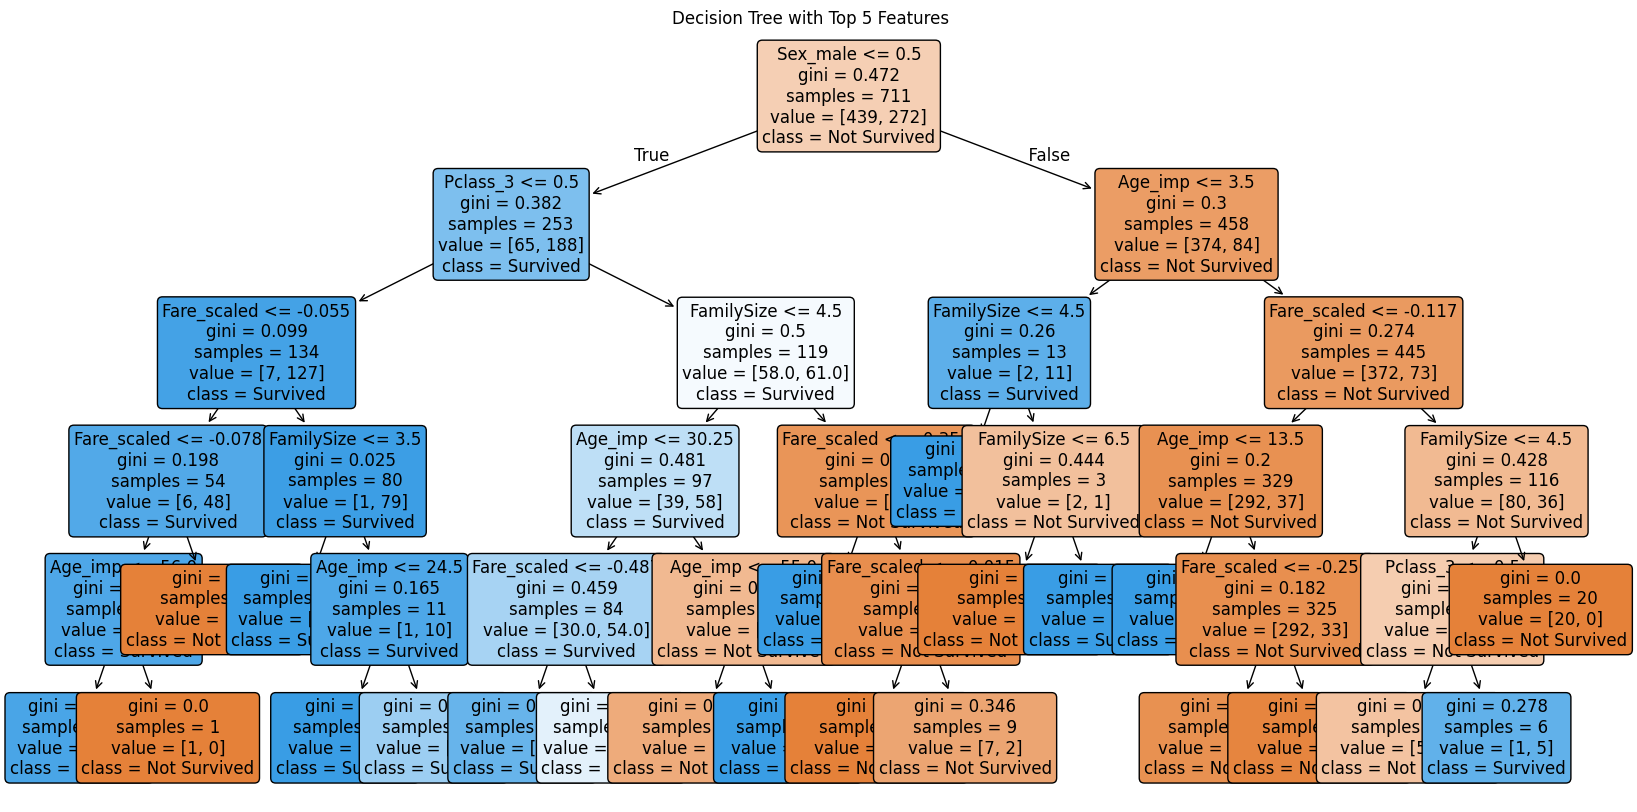

Baseline Decision Tree CV ROC AUC scores: [0.86330214 0.86022727 0.79979947 0.87927807 0.82433891]
Mean CV ROC AUC: 0.8454 ± 0.0290
Selected Features Decision Tree CV ROC AUC scores: [0.87152406 0.85661765 0.80280749 0.87927807 0.8254857 ]
Mean CV ROC AUC: 0.8471 ± 0.0288


In [11]:
# Prepare data
df = titanic[columns_to_use].copy()

# Convert target and Pclass to categorical
df['Survived'] = df['Survived'].astype('category')
df['Pclass'] = df['Pclass'].astype('category')

# Separate features and target
X = df.drop('Survived', axis=1)
y = df['Survived']

# One-hot encode categorical features (Pclass, Embarked_Q, Embarked_S, Sex_male are already numeric/bool except Pclass)
X = pd.get_dummies(X, drop_first=True)

# Train-test split with stratify on target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Baseline Decision Tree model
dt = DecisionTreeClassifier(random_state=42, max_depth=5)
dt.fit(X_train, y_train)

# Feature importances
importances = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Feature importances:\n", importances)

# Select top 5 important features
top_features = importances.head(5).index.tolist()
print("\nTop 5 features:", top_features)

# Retrain model with selected features
dt_selected = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_selected.fit(X_train[top_features], y_train)

# Plot tree with selected features
plt.figure(figsize=(20,10))
plot_tree(dt_selected,
          feature_names=top_features,
          class_names=['Not Survived', 'Survived'],
          filled=True,
          rounded=True,
          fontsize=12)
plt.title('Decision Tree with Top 5 Features')
plt.show()

# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate baseline model with cross-validation
dt_cv = DecisionTreeClassifier(random_state=42, max_depth=5)
cv_scores = cross_val_score(dt_cv, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"Baseline Decision Tree CV ROC AUC scores: {cv_scores}")
print(f"Mean CV ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Evaluate selected features model with cross-validation
dt_selected_cv = DecisionTreeClassifier(random_state=42, max_depth=5)
cv_scores_selected = cross_val_score(dt_selected_cv, X[top_features], y, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"Selected Features Decision Tree CV ROC AUC scores: {cv_scores_selected}")
print(f"Mean CV ROC AUC: {cv_scores_selected.mean():.4f} ± {cv_scores_selected.std():.4f}")

In [19]:
# Define scorers for cross_val_score
scorers = {
    'precision': make_scorer(precision_score, pos_label=1, zero_division=0),
    'recall': make_scorer(recall_score, pos_label=1, zero_division=0),
    'f1': make_scorer(f1_score, pos_label=1, zero_division=0)
}

# Function to evaluate model with multiple metrics using cross-validation
def evaluate_model_cv(model, X, y, cv, scorers):
    results = {}
    for metric_name, scorer in scorers.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)
        results[metric_name] = (scores.mean(), scores.std())
    return results

# Evaluate baseline model
dt_cv = DecisionTreeClassifier(random_state=42, max_depth=5)
baseline_metrics = evaluate_model_cv(dt_cv, X, y, cv, scorers)

# Evaluate selected features model
dt_selected_cv = DecisionTreeClassifier(random_state=42, max_depth=5)
selected_metrics = evaluate_model_cv(dt_selected_cv, X[top_features], y, cv, scorers)

# Print results
print("Baseline Decision Tree CV metrics:")
for metric, (mean_score, std_score) in baseline_metrics.items():
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

print("\nSelected Features Decision Tree CV metrics:")
for metric, (mean_score, std_score) in selected_metrics.items():
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Baseline Decision Tree CV metrics:
Precision: 0.7968 ± 0.0325
Recall: 0.6794 ± 0.0717
F1: 0.7303 ± 0.0381

Selected Features Decision Tree CV metrics:
Precision: 0.7982 ± 0.0372
Recall: 0.6912 ± 0.0714
F1: 0.7371 ± 0.0339


Hincal Comment:

Cross-Validation results show:

- Baseline Decision Tree (all features):

- Mean ROC AUC = 0.8454 ± 0.0290

- Selected Features Decision Tree (top 5 features):

- Mean ROC AUC = 0.8471 ± 0.0288

- The model trained on the top 3 most important features slightly outperforms the baseline model using all features.

- The difference is small but consistent across folds.

- This suggests that focusing on the most important features can simplify the model without sacrificing performance.

- Also, simpler models are easier to interpret and faster to train.

- The model with selected features slightly improves recall and F1 score while maintaining precision.

- This suggests that focusing on the most important features can yield a more balanced and slightly better-performing model.

---

Hincal Comment:

Now we will create KNeighborsClassifier, SVM, and a Keras Neural Network models on same dataset and features(which we get from DecisionTreeClassifier Model)

In [27]:
top_features.remove('Pclass_3')
top_features

['Sex_male', 'Age_imp', 'FamilySize', 'Fare_scaled']

In [29]:
top_features.append('Pclass')
top_features

['Sex_male', 'Age_imp', 'FamilySize', 'Fare_scaled', 'Pclass']

            Accuracy  Precision    Recall  F1 Score   ROC AUC
Model                                                        
KNeighbors  0.735955   0.690909  0.558824  0.617886  0.800401
SVM         0.646067   0.692308  0.132353  0.222222  0.802273
Keras NN    0.814607   0.843137  0.632353  0.722689  0.849599


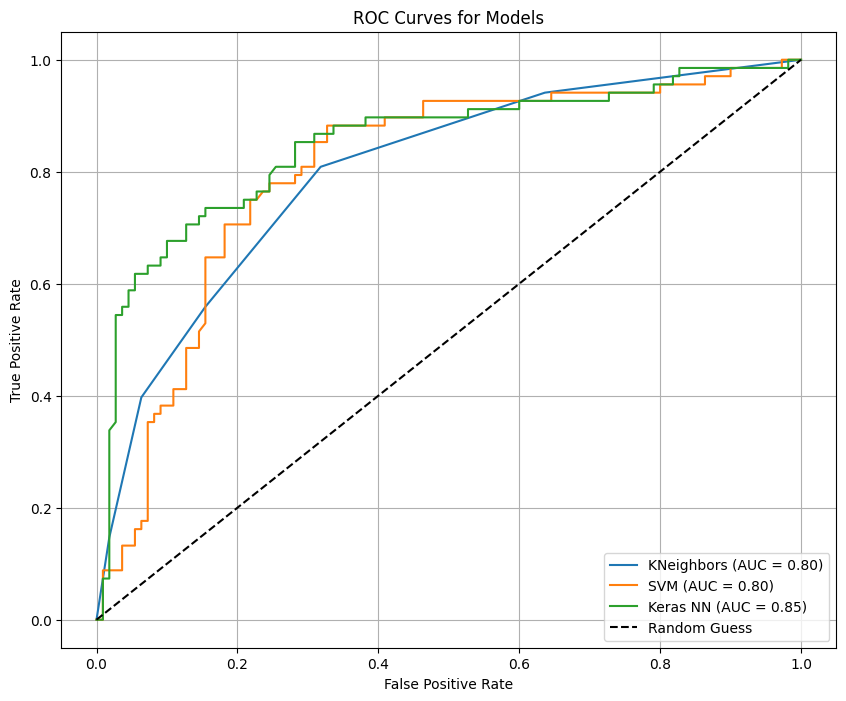

In [30]:
# For demonstration, replace with your actual data:
X = df[top_features].copy()
y = y.astype(int)  # Ensure target is integer 0/1

X = pd.get_dummies(X, drop_first=False)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Align columns to ensure same features in train and test
#X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Define Keras model function
def create_keras_model():
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap Keras model for scikit-learn compatibility
keras_clf = KerasClassifier(model=create_keras_model, epochs=50, batch_size=32, verbose=0)

# Initialize other models
knn = KNeighborsClassifier()
svm = SVC(probability=True, random_state=42)

# Dictionary of models
models = {
    'KNeighbors': knn,
    'SVM': svm,
    'Keras NN': keras_clf
}

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # For KerasClassifier and SVM with probability=True, predict_proba exists
        # Otherwise fallback to decision_function or use predictions as probabilities
        try:
            y_proba = model.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # scale to [0,1]
        except:
            y_proba = y_pred  # fallback

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    }
    return metrics

# Evaluate all models and collect results
results = []
for name, model in models.items():
    metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
    metrics['Model'] = name
    results.append(metrics)

# Create results DataFrame
results_df = pd.DataFrame(results).set_index('Model')
print(results_df)

# Optional: Plot ROC curves for all models
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        try:
            y_proba = model.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        except:
            y_proba = None
    if y_proba is not None:
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Hincal Comment:

Interpretation
- Keras Neural Network performs best overall, with highest accuracy, precision, recall, F1 score, and ROC AUC.
- KNeighbors has decent accuracy and precision but lower recall and F1.
- SVM shows relatively low recall and F1 despite reasonable precision and ROC AUC, indicating it misses many positive cases.

This study is done by Hincal Topcuoglu. Thank you